# 1. Explore the models

Welcome to the guide for the ANDI 2 challenge datasets. In this notebook we will explore the new diffusion models considered for the challenge. As opposed to the diffusion models of the previous challenge (check the [paper](https://www.nature.com/articles/s41467-021-26320-w) and the [previous tutorial](challenge_one_datasets.ipynb) ), this time we focus on *phenomenological* models. That is, models in which diffusion properties arise from the interaction of the moving particle with the environment, or due to its inherent properties. Moreover, we will focus in models in which diffusive changes happened randomly, because of different reasons. Nonetheless, we are still in the ANDI Challenge, so *anomalous* is still here! All particles will diffuse following fractional Brownian motion, with different anomalous exponents $\alpha$. We have developed 5 types of diffusion, with which we want to cover most of the phenomena one encounters in real, physical, scenarios. Before reviewing them, let us set some initial conditions which will be considered in all models. These parameters will be similar to the ones considered in the datasets generated for the challenge.

#### Experimental diffusion conditions

##### Field of view `fov` and system size `L`
We consider the trajectories to be recorded by a device with field of view $128 \times 128 px^2$, with a pixel size of 100 nm. In order to avoid boundary effects, we will usually simulate the diffusion in a box of size $L =1.5 \ \times$ `fov`.

##### Frame rate
In the same spirit, we consider a tracking device working at a frame rate of $0.1 Hz$. This means that each time step of the particle $\Delta t = 100 \ ms  = 0.1 \ s$. 

##### Diffusion coefficient `D`
Typically, microparticles in biological environments diffuse with coefficients of the order of $0.01 \ \mu m^2/s$. In order to get a meaningful input value for the diffusion model generators, we need to consider the following:

- As a working definition of $D$, valid also for anomalous diffusion, we consider it as proportional to the variance of the displacements along one dimension at the shortest time lag, i.e. $\sigma_{\Delta x}^2= 2  D \Delta t$.
    
- Given the values of pixel size and frame rate, in adimensional units, $D$ is given by: $D= 0.01 \ \frac{\mu m^2}{s} \ \frac{0.1 s/ \Delta t }{  0.01 \mu m^2/px^2} = 0.1 \ px^2/\Delta t$.

##### Localization precision `sigma_x`
To replicate experimental conditions, we usually consider the presence of uncorrelated noise in the tracking of the particles. This is taken into account by considering a localization precision of $\sigma_{x} = 12 \ nm = \frac{12 \ nm} {100 \ nm/px}  = 0.12 \ px$.

# Creating trajectories from phenomenolgical models
All models are gathered in a single class, easily accessed using the cell below. We will also import some usefull libraries to showcase some of the properties of the models. After that,  we are ready to explore the various diffusion models available.

In [ ]:
from andi_datasets.models_phenom import models_phenom

# auxiliaries
import stochastic
import numpy as np
import matplotlib.pyplot as plt

stochastic.random.seed(3)
np.random.seed(7)

### Model 1 - Single state diffusion
This is the most *boring* model of all... It simulates a particle with a single diffusive state, with an associated $D$ and $\alpha$. This kind of trajectories can also be generated with the class `models_theory`, check [its associated tutorial](challenge_one_datasets.ipynb) to know more. 

All models have similar inputs, with some changing to accomodate the particularities of each model. In general, we input the number of trajectories to be generated `N`, the number of time steps `T`, and then length of the box acting as environment `L`. Let us define these and keep them for the rest of the notebook. We will also define here the diffusion coefficient.

In [ ]:
# number of time steps per trajectory (frames)
T = 500
# number of trajectories
N = 100
# Length of box (pixels)
L = 1.5*128
# diffusion coefficient (pixels^2 / frame)
D = 0.1

To generate the trajectories, we can choose to either provide a fixed value for $D$ and $\alpha$, or a list containing a mean and a variance. In the second case, the property is sampled from a normal distribution for every trajectory. Let's generate some trajectories with fixed anomalous exponent `alpha = 0.5`, and random diffusion coefficients with a fixed mean. Remember that all trajectories follow FBM!

The output of all the phenomenological models is always the same: a tuple containing the trajectories and their labels. Let's focus on the first now:

In [ ]:
trajs_model1, _ = models_phenom().single_state(N = N, 
                                                L = L,
                                                T = T,
                                                Ds = [D, 0.1], # Mean and variance
                                                alphas = 0.5
                                                )

The trajectories will have always the same shape: (time, number of trajectories, number of dimensions). In this challenge, we always consider two dimensions.

In [ ]:
trajs_model1.shape

(500, 100, 2)

Let's take a look at some of the trajectories with a built-in function from the library:

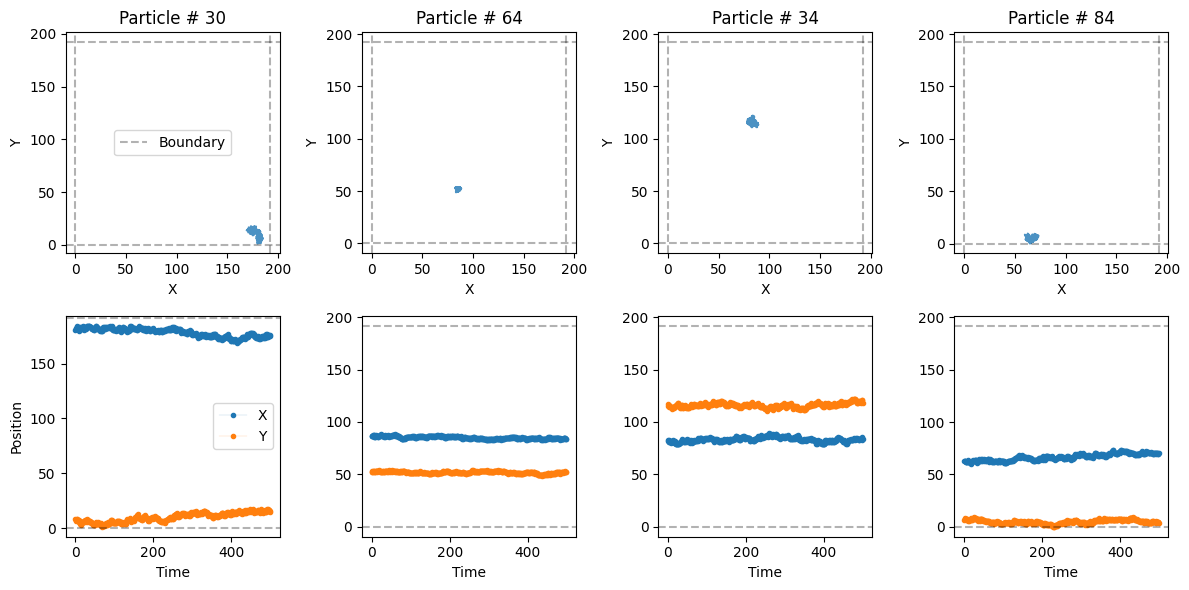

In [ ]:
from andi_datasets.utils_trajectories import plot_trajs

plot_trajs(trajs_model1, L, N, num_to_plot = 4)

### Model 2 - Multiple state diffusion
Now we consider the motion of a particle that changes between different diffusive state. We are free to choose the number of states. The probability of jumping from one state to another is given by the transition matrix $M$. Let's consider a two-state diffusion process. It's transition matrix is

$M = \begin{pmatrix} P_{11} & P_{12} \\ P_{21} & P_{22} \end{pmatrix} = \begin{pmatrix} 0.98 & 0.02 \\   0.02 & 0.98 \end{pmatrix},$

where $P_{ij}$ is the probability of changing from state $i$ to state $j$ at every time step. Each diffusive state can have its own diffusion coefficient and anomalous exponent. For instance, we consider a fast state with $D_f = 10 D$ and $\alpha_f = 1.2$ and a slow state with $D_s = 0.1 D$ and $\alpha_s = 0.7$. Let's create some trajectories! 

In [ ]:
trajs_model2, labels_model2 = models_phenom().multi_state(N = N, 
                                                          L = L,
                                                          T = T,
                                                          alphas = [1.2, 0.7], # Fixed alpha for each state
                                                          Ds = [[10*D, 0.1], [0.1*D, 0.0]], # Mean and variance of each state
                                                          M = [[0.98, 0.02], [0.02, 0.98]]
                                                            )

See that now we do care about the trajectory labels. They contain very important information: the value of $\alpha$, $D$ and the state of the particle at every time step.

In [ ]:
labels_model2.shape

(500, 100, 3)

For instance, let's check the values of the labels for the first particle:

In [ ]:
print(r'alphas:', np.unique(labels_model2[:, 0, 0]), 'D:', np.unique(labels_model2[:, 0, 1]) )

alphas: [0.7 1.2] D: [0.01       0.77367364]


The state of the particle does not correspond to the actual diffusive state.
Even though there are two diffusive states in these trajectories, the label is always `2`, which corresponds to a free particle.

In [ ]:
np.unique(labels_model2[..., -1])

array([2.])

The different states are:

    - `0`: immobile
    - `1`: confined
    - `2`: free
    - `3`: directed

In [ ]:
models_phenom().lab_state

['i', 'c', 'f', 'd']

Now, let's plot some trajectories to see their changes over time. In the third row of the next plot, we see the value of $\alpha$ and $D$ over time with vertical lines marking the changepoints.

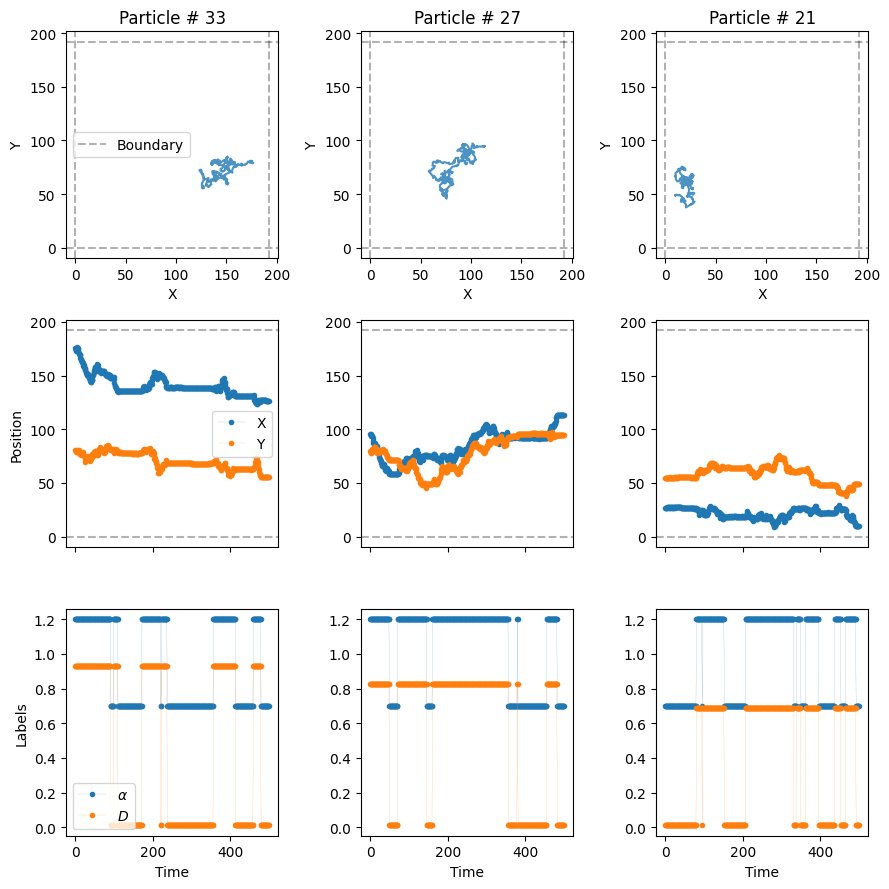

In [ ]:
plot_trajs(trajs_model2, L, N, labels = labels_model2, plot_labels = True)

W can see, $\alpha$ and $D$ change over time randomly, following the transition matrix $M$. We can also work with changepoints and physical properties in the different systems with the following function:

In [ ]:
from andi_datasets.utils_challenge import label_continuous_to_list

changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model2[:, 0, :])

print('changepoints:', changepoints,
      '\nalphas:', alphas,
      '\nDs:', Ds)

changepoints: [ 83 199 218 244 348 385 408 500] 
alphas: [1.2 0.7 1.2 0.7 1.2 0.7 1.2 0.7] 
Ds: [0.77367364 0.01       0.77367364 0.01       0.77367364 0.01
 0.77367364 0.01      ]


This results in $C$ changepoints, which create $C+1$ segments, and hence $C+1$ values of $\alpha$ and $D$.

### Model 3 - Dimerization
The third model considers a set of trajectories moving all in the same environment. They have all the same properties: $D$, $\alpha$ and radius $r$. If two particles get closer than a distance $2r$, they bind with probability $P_b$ creating a dimer. Similarly, two dimerized particles may unbind with probability $P_u$. This results in two diffusive states. Just as before, we can define the diffusion coefficients and exponents of both states. Let's see an example:

In [ ]:
trajs_model3, labels_model3 = models_phenom().dimerization(N = N, 
                                                           L = L,
                                                           T = T,
                                                           alphas = [1.2, 0.7], # Fixed alpha for each state
                                                           Ds = [10*D, 0.1*D], # Fixed D for each state
                                                           r = 1, # Radius of the particles
                                                           Pb = 1, # Binding probability
                                                           Pu = 0 # Unbinding probability
                                                           )

Now, let's plot the trajectories to see how particles dimerize.

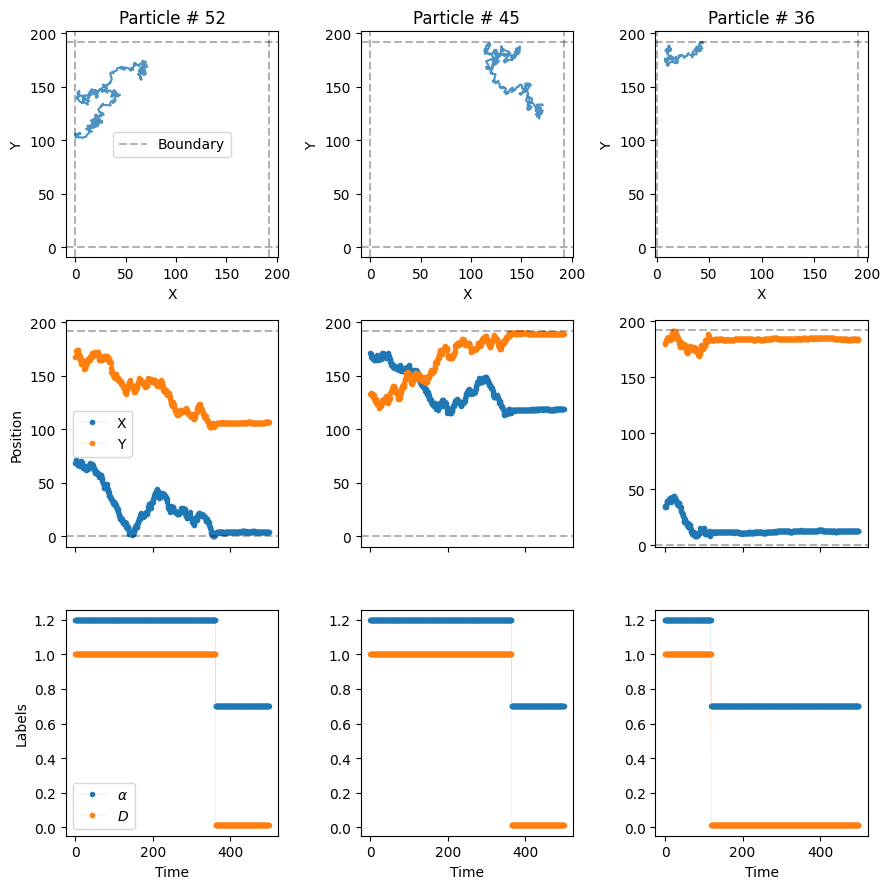

In [ ]:
plot_trajs(trajs_model3, L, N, labels = labels_model3, plot_labels = True)

In the third row of the plot, we can see how the diffusve state changes when the particles dimerize! Since we have set $P_u=0$, once the particles dimerize, they remain bound for the rest of the experiment.

### Model 4 - Immobile traps
The fourth model considers the presence of fixed traps of radius $r$ which completely immobilize the particles. Similar to the dimerization model, the particles have a probability $P_b$ of getting trapped and $P_u$ of getting released whenever they are within the area of the trap. The generator of this trajectories allows us (optional) to set the position of the traps beforehand. Let's throw them randomly over the box:

In [ ]:
number_traps = 100
traps_positions = np.random.rand(number_traps, 2)*L 

Now, let's put some particles in the system with the usual diffusion coefficient $D$ and an $\alpha = 1.6$.

In [ ]:
trajs_model4, labels_model4 = models_phenom().immobile_traps(N = N,
                                                             T = T,                
                                                             L = L,
                                                             r = 2, # Radius of the traps
                                                             Pu = 0.01, # Unbinding probability
                                                             Pb = 1, # Binding probability
                                                             Ds = D, # Diffusion coefficients of moving state
                                                             alphas = 1.6, # Anomalous exponents of moving state
                                                             Nt = number_traps, # Number of traps
                                                             traps_pos = traps_positions
                                                             )

In this case, besides $\alpha$ and $D$, the labels also tell us when the particle is trapped with the label `0`.

In [ ]:
np.unique(labels_model4[..., -1])

array([0., 2.])

Let's see some trajectory examples.

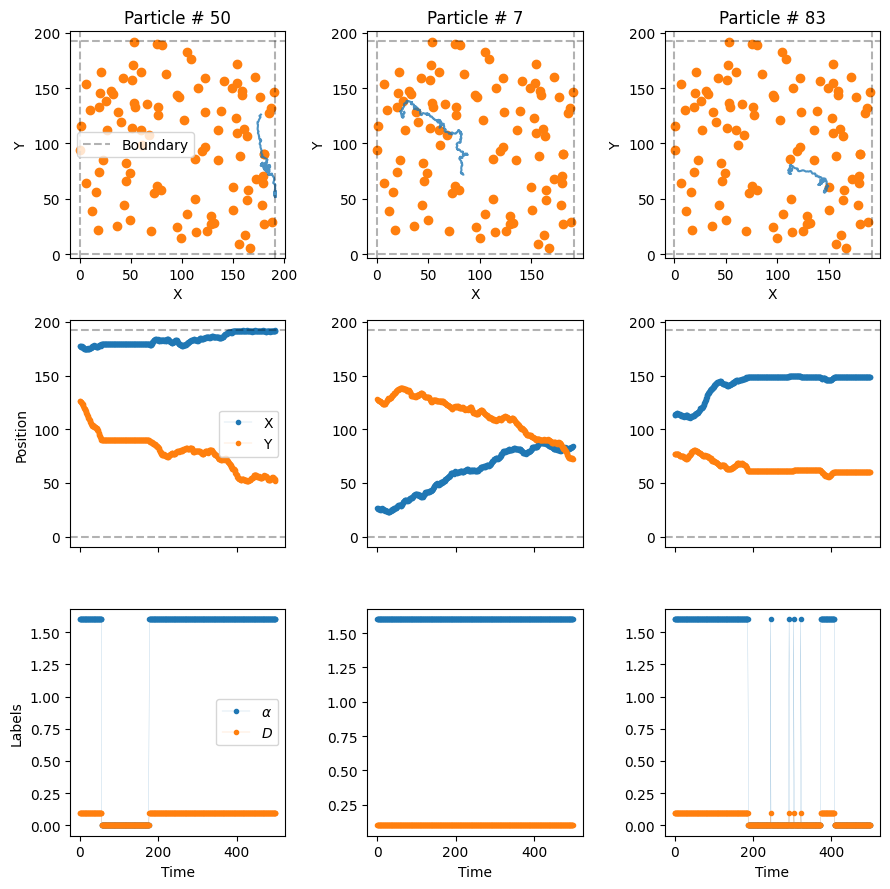

In [ ]:
plot_trajs(trajs_model4, L, N, 
           labels = labels_model4, plot_labels = True,
           traps_positions = traps_positions)


The particles superdiffuse until they hit a trap, moment in which they get immobilized. In some cases, the particles may avoid the traps entirely and never be bound! (The size of the dot is not the size of the trap)

### Model 5 - Confinement
Last but not least, we have one of the most relevant models of the challenge: the presence of compartments, whose boundaries can prevent particles from escaping them. Note that we consider here the case of *osmotic* boundaries, which means that particles will always enter the compartment. Once inside, the boundaries have a certain transmittance `trans`, i.e., the probability of the particle exiting the compartment. Just as the case of immobile traps, we can define (optionally) the compartments' distribution a priori. Note that we always consider here circular compartments of fixed radius `r`. We can use the following built-in function to distribute cercles over the environment without overlap. If the algorithm does not manage to place them all, it raises a warning, and only the circles that fit are placed.

In [ ]:
number_compartments = 50
radius_compartments = 10
compartments_center = models_phenom._distribute_circular_compartments(Nc = number_compartments, 
                                                                      r = radius_compartments,
                                                                      L = L # size of the environment
                                                                      ) 

Let's check the distribution of the compartments. The environment is quite dense!

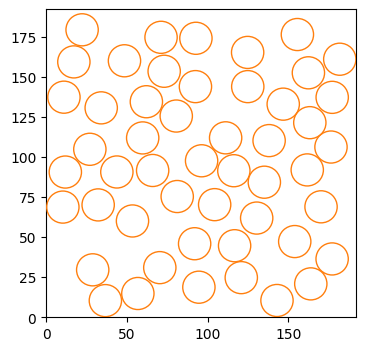

In [ ]:
fig, ax = plt.subplots(figsize = (4,4))
for c in compartments_center:
    circle = plt.Circle((c[0], c[1]), radius_compartments, facecolor = 'None', edgecolor = 'C1', zorder = 10)
    ax.add_patch(circle) 
plt.setp(ax, xlim = (0, L), ylim = (0, L));

Now, let's introduce some diffusive particles in this environment. We will consider a rather extreme case to nicely show the effect of the compartments. Outside the comparments, the particles will move very, very fast, at $D_f = 1500D$. Replicating what we see in many biological scenarios, the particles will move much slower, $D_s = 50 D$, inside the compartments. Let's keep the same $\alpha = 1$ for both diffusive states.

**Comment on default values:** the default values for `alpha` are always 1 for all methods. Hence, if no exponents are given, all diffusive states are normally diffusing. Most of the arguments of the functions presented in this tutorial have default values similar to the ones used in this notebook. If you want to know more, you can check their [source code](../lib_nbs/models_phenom.ipynb).

Let's consider a transmittance `trans` = 0.2 for the compartment boundaries:

In [ ]:
trajs_model5, labels_model5 = models_phenom().confinement(N = N,
                                                          L = L,
                                                          Ds = [1500*D, 50*D],
                                                          comp_center = compartments_center,
                                                          r = radius_compartments,
                                                          trans = 0.2 # Boundary transmittance
                                                           )

Let's see the resulting trajectories, superimposed to the cercles we created just before.

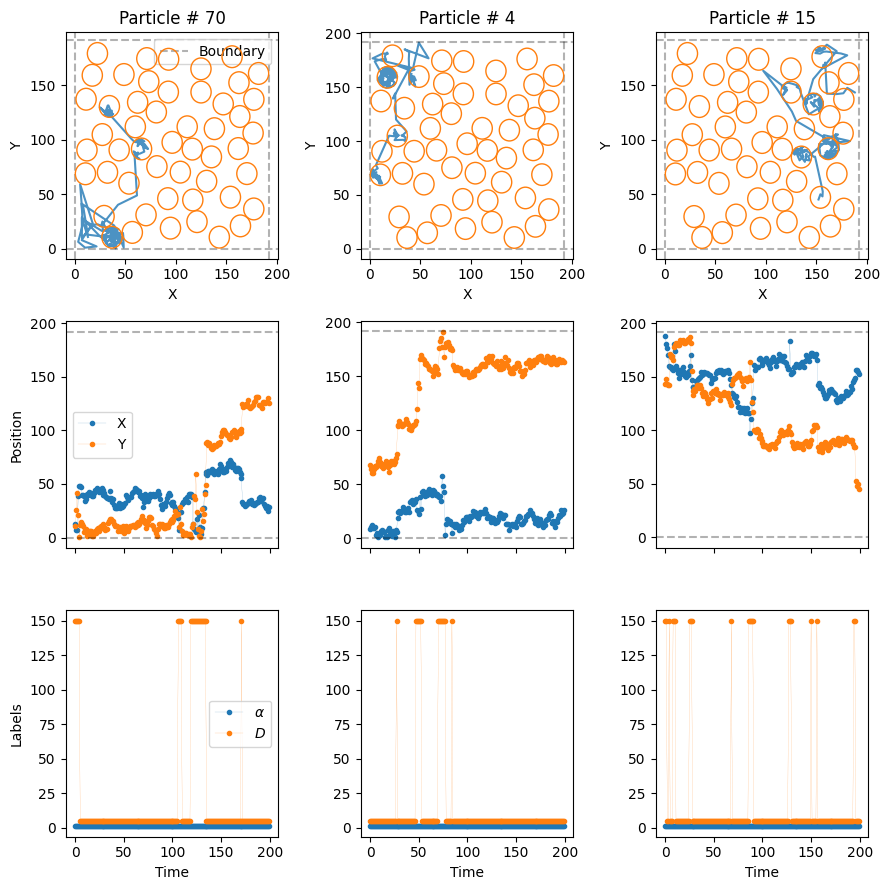

In [ ]:
plot_trajs(trajs_model5, L, N, 
           comp_center = compartments_center,
           r_cercle = radius_compartments,
           plot_labels = True, labels = labels_model5
           )

With these extreme diffusion coefficients, the particles move very fast from one compartment to the other. Once inside, the low transmittance of the boundaries make it such that they stay for some time before they exit!

#  Creating datasets with multiple models

The library allows to simultaneously generate trajectories from all the previous models, and gather them in a single dataset. To do so, we have created the the class `datasets_phenom`. Let's import it and see some of its properties:

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom

One of the first things we can check is the models that we can access with this class. Spoiler: they are the same we just reviewed above!

In [ ]:
datasets_phenom().avail_models_name

['single_state',
 'multi_state',
 'immobile_traps',
 'dimerization',
 'confinement']

As we have seen previously, each model has its own parameters. Most of them have some sensible default values, so we can generally skip them when generating trajectories. Nonetheless, we can always easily see what are the parameters for a given model:

In [ ]:
model = 'confinement'
datasets_phenom()._get_inputs_models(model)

['N',
 'T',
 'L',
 'Ds',
 'alphas',
 'gamma_d',
 'epsilon_a',
 'r',
 'comp_center',
 'Nc',
 'trans',
 'deltaT']

Of course, we encourage you to also check the [documentation](https://andichallenge.github.io/andi_datasets/) and inspect all the details about the models.

In order to generate trajectories, we first need to set:
1. the models we want to generate trajectories from 
2. the properties of each of the models. 

To do so, we need to create a *dictionary* that stores all the needed information for each model. Hence, for multiple models, we will need to input a list of dictionaries. For example, let's create a dataset with trajectories from the dimerization (model 3) and confinement (model 5) models. We will make use of the default values of the previous models, and only input the binding/unbinding probability for the former and the transmittance for the latter.

In [ ]:
dict_model3 = {'model': 'dimerization', 
               'L': L,
               'Pu': 0.1, 'Pb': 1}

dict_model5 = {'model': 'confinement', 
               'L': L,
               'trans': 0.2}

dict_all = [dict_model3, dict_model5]

trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                                )

The trajectories arising from the previous function are ordered following the order of the input list of dictionaries. We requested `N_model = N = 100` trajectories per model, hence the dataset will have a total of 200 trajectories. The first 100 will come from the dimerization model and the last 100 from the confinement model.

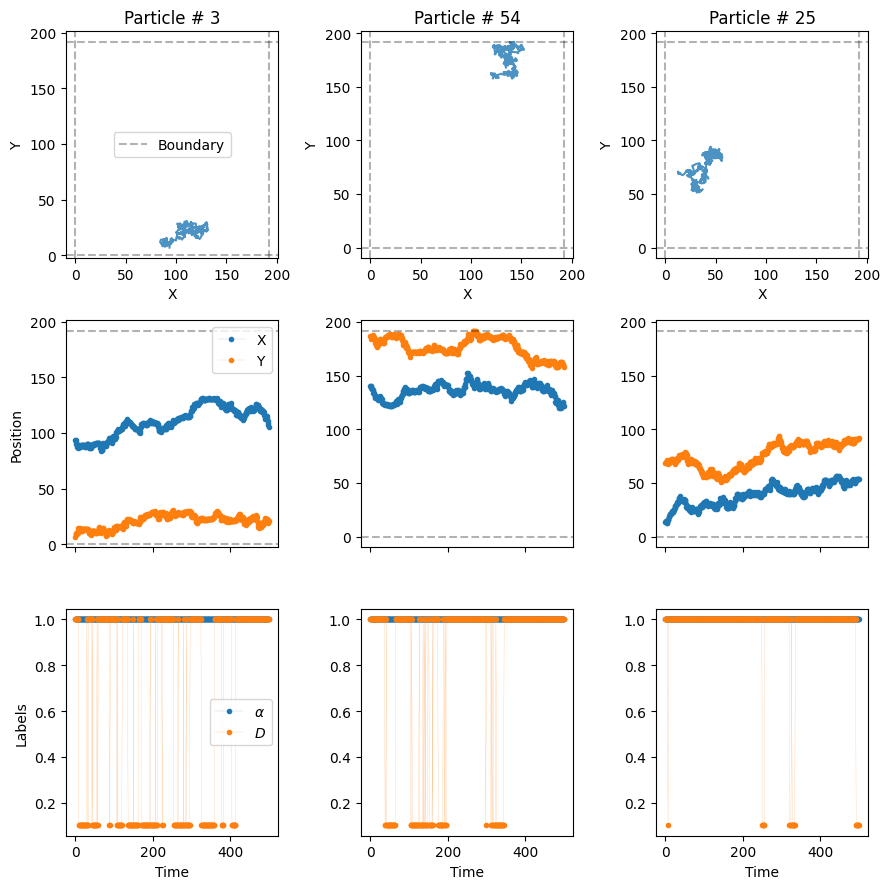

In [ ]:
from andi_datasets.utils_trajectories import plot_trajs

plot_trajs(trajs, L, N, 
           plot_labels = True, labels = labels
           )

### Saving and loading datasets

Just as with the `datasets_theory` class (check here the details), you can save and load datasets, so that you avoid creating trajectories every time you need them. The same function presented above has such options:

In [ ]:
trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                                 save = True, path = 'datasets_folder/'
                                                )

Saving creates two files per model:

   - a ``.csv`` file, containing the details of the dataset generated. This file stores the values of the parameters of the saved dataset. This file helps organizing all the saved datasets and is used later to know, given some parameters, from where to load the trajectories.
    
   - a ``.npy`` file, containing the trajectories and labels of the generated trajectories. Each file will have an integer number at end, which is used, together with the csv file, in order to know the properties of the dataset.
   
After saving, we can just load the dataset with the same function:

In [ ]:
trajs, labels = datasets_phenom().create_dataset(N_model = N, # number of trajectories per model
                                                 T = T,
                                                 dics = dict_all,
                                                 load = True, path = 'datasets_folder/'
                                                )

# Generating the ANDI 2 challenge dataset

Here we showcase how to generate the exact same dataset used as training / public dataset in the Codalab competition. 

In [ ]:
# Generic libraries
import pandas as pd
import numpy as np

# Functions needed from andi_datasets
from andi_datasets.datasets_challenge import challenge_phenom_dataset, _get_dic_andi2
from andi_datasets.utils_challenge import file_nonOverlap_reOrg

### Defining the dataset properties

**Setting a single FOV per experiment:** In order to have the most heterogeneous dataset, we will avoid overlapping FOVs by generating various experiments for each condition and then a single FOV for each of this. Then, we will use the function `file_nonOverlap_reOrg` to reorganize the data in the form proposed in the challenge. This makes the simulations much more efficient, since we need to consider environments with less particles to generate every fov.

Our goal is to have 10 experiments (2 per phenomenological model) with 30 FOVs each. This means that we will generate 300 independent experiments, but considering that batches of 30 have the exact same properties. After generating this data, we will reorganize the dataset to have the structure proposed in the challenge.

The first experiment for each model will be sampled using the default parameters (given by `_get_dic_andi2` and defined in `_defaults_andi2`). Then, we will show how to customize the parameters for the second experiment of each model. These second ones will be "easy" with clearly differentiated diffusie states. We will also do some tweaks to make them interesting!

As in the previous example, the details for every experiment need to be provided in a list of dictionaries. Let's start with the first experiment for each diffusion model using the default parameters.

In [ ]:
MODELS = np.arange(5)
NUM_FOVS = 30
PATH = 'andi2_dataset/' # Chose your path!

dics = []

for m in MODELS:   
    dic = _get_dic_andi2(m+1)

    # Fix length and number of trajectories 
    dic['T'] = 200 
    dic['N'] = 100

    # Add repeated fovs for the experiment
    for _ in range(NUM_FOVS):
        dics.append(dic)

Now let's add the second experiment for each model with their customized settings.

In [ ]:
dic

{'N': 100,
 'T': 200,
 'L': 230.4,
 'Ds': array([[1.00782524e+00, 1.00782524e-02],
        [4.25269232e-02, 4.25269232e-04]]),
 'alphas': array([[1.07658492, 0.01      ],
        [0.70302885, 0.01      ]]),
 'model': 'confinement',
 'r': 5,
 'Nc': 30,
 'trans': 0.1}

In [ ]:
for m in MODELS:   
    dic = _get_dic_andi2(m+1)

    # Fix length and number of trajectories 
    dic['T'] = 200 
    dic['N'] = 100

    #### SINGLE STATE ####
    if m == 0:  
        dic['alphas'] = np.array([1.5, 0.01])
        dic['Ds'] = np.array([0.01, 0.01])
            
            
    #### MULTI STATE ####
    if m == 1:
        # 3-state model with different alphas            
        dic['Ds'] = np.array([[0.99818417, 0.01],
                              [0.08012007, 0.01],
                              [1.00012007, 0.01]])

        dic['alphas'] = np.array([[0.84730977, 0.01],
                                  [0.39134136, 0.01],
                                  [1.51354654, 0.01]])

        dic['M'] = np.array([[0.98, 0.01, 0.01],
                             [0.01, 0.98, 0.01],
                             [0.01, 0.01, 0.98]]) 
        
    #### IMMOBILE TRAPS ####
    if m == 2:
        dic['alphas'] = np.array([1.9, 0.01])
            
    
    #### DIMERIZATION ####
    if m == 3:
        dic['Ds'] = np.array([[1.2, 0.01],
                              [0.02, 0.01]])

        dic['alphas'] = np.array([[1.5, 0.01],
                                  [0.5, 0.01]])
        dic['Pu'] = 0.02
        
    #### CONFINEMENT ####
    if m == 4:
        dic['Ds'] = np.array([[1.02, 0.01],
                              [0.01, 0.01]])

        dic['alphas'] = np.array([[1.8, 0.01],
                                  [0.9, 0.01]])
        
        dic['trans'] = 0.2

    # Add repeated fovs for the experiment
    for _ in range(NUM_FOVS):
        dics.append(dic)

In [ ]:
challenge_phenom_dataset(save_data = True,
                         dics = dics,
                         path = PATH, return_timestep_labs=True, 
                         num_fovs = 1,
                         get_video = True, num_vip=10);

  0%|          | 0/4 [00:00<?, ?it/s]

Creating dataset for Exp_0 (single_state).
Generating video for EXP 0 FOV 0
Creating dataset for Exp_1 (single_state).
Generating video for EXP 1 FOV 0
Creating dataset for Exp_2 (multi_state).
Generating video for EXP 2 FOV 0
Creating dataset for Exp_3 (multi_state).
Generating video for EXP 3 FOV 0


#### Organizing in challenge form

> What we are going to explain now, can be done by setting `reorg_files=True` in the previous function `challenge_phenom_dataset`.

Merging and reorganizing the dataset generated in the challenge form. Considering that you want to **also save the labels**, the structure is as follows:

    
```
PATH
│
└─── track_1 (videos)
|   │
|   └─── exp_Y
│        │
│        └─── videos_fov_X.tiff (video for each fov)
│        │
│        └─── ensemble_labels.txt (information at the ensemble level for the whole experiment)
│        │
│        └─── traj_labs_fov_X.txt (information for each trajectory for the whole experiment)
│        │
│        └─── ens_labs_fov_X.txt (information at the ensemble level for each FOV)
│        │
│        └─── vip_idx_fov_X.txt (index of VIP particles)
│ 
│
└─── track_2 (trajectories)
    │
    └─── exp_Y
        │
        └─── traj_fov_X.txt (trajectories for each FOV) 
        │
        └─── ensemble_labels.txt (information at the ensemble level for the whole experiment)
        │
        └─── traj_labs_fov_X.txt (information for each trajectory for the whole experiment)
        │
        └─── ens_labs_fov_X.txt (information at the ensemble level for each FOV)
```

For **unlabelled** datasets like the one provided in the challenge, the structure is as follows:

```
PATH
│
└─── track_1 (videos)
|   │
|   └─── exp_Y
│        │
│        └─── videos_fov_X.tiff (video for each fov)
│ 
│
└─── track_2 (trajectories)
    │
    └─── exp_Y
        │
        └─── traj_fov_X.txt (trajectories for each FOV) 
```



In [ ]:
target_folder = PATH + 'ref/' # this name is important for later stages.
raw_folder = PATH

# If you want to save all data, including labels, the following must be True
# If you only want to save trajectories / videos in the challenge structure,
# change to False
save_labels = True

file_nonOverlap_reOrg(raw_folder = raw_folder,
                      target_folder = target_folder, 
                      experiments = EXPERIMENTS,
                      num_fovs = NUM_FOVS,
                      save_labels= save_labels)

Experiment 0: 1.0
Experiment 1: [0.28 0.39 0.33]


# Scoring your predictions

All the scoring programs used in codalab are also available in the library. Here is an example with the dataset we just generated. 

To simplify, we will use the same dataset we just generated as submission. **We will consider here only Track 2 too**. As groundtruth and predictions are the same, the metrics will always be perfect! 

The structure for a prediction follows the same pattern as the reference. For the program to work, the groundtruth /reference must be in a folder called `ref` and the predictions / results in a folder called `res`, both placed in the `PATH`. The whole structure should be as following:

```
PATH
│
└─── ref (the one you created and reorganized above. Should contain labels, i.e. save_labels = True)
|
└─── res (the one containing your predictions)
    │
    └─── track_1 
    |   │
    |   └─── exp_Y
    │        │
    │        └─── fov_X.tiff (predictions for VIP particles for each FOV)
    │        │
    │        └─── ensemble_labels.txt (predictions at the ensemble level for the whole experiment)
    │ 
    │
    └─── track_2 
        │
        └─── exp_Y
            │
            └─── fov_X.txt (predictions for single trajectories for each FOV)
            │
            └─── ensemble_labels.txt (predictions at the ensemble level for the whole experiment)
```

Note that you can choose to participate just in one of the tracks (video or trajectories) or tasks (ensemble or single trajectory). This will not rise an error in the scoring program, just None predictions to the rest. As we are here participating just in Track 2, all scores for Track 1 will be set to their maximum possible values (these can be found in the challenge description or in `utils_challenge._get_error_bounds`.

**Note:** You can skip the following if you have created your own predictions.

To proceed, we copy the `ref` folder, name the new copy `res`, and delete the `track_1` folder. Then, we use the following function to transform the reference dataset into a submission dataset (mostly changes the names of the files `traj_labs_fov_X.txt` into `fov_X.txt`.

In [ ]:
from andi_datasets.utils_challenge import transform_ref_to_res

In [ ]:
transform_ref_to_res(base_path = PATH + 'res/',
                     track = 'track_2',
                     num_fovs = NUM_FOVS)                 

To score your predictions, you just need to run:

In [ ]:
from andi_datasets.utils_challenge import codalab_scoring

In [ ]:
PATH = 'andi2_dataset/'

In [ ]:
codalab_scoring(INPUT_DIR = PATH,
                OUTPUT_DIR = '.')

The warnings give you important information about missing tracks, tasks and others. The results are then give in two formats: 

- `scores.txt`: this file contains the average values over all experiments for the different Tracks and Tasks. If you followed this example and didn't include you own predictions, it should look like this:

```
tr1.ta1.alpha: 2
tr1.ta1.D: 100000.0
tr1.ta1.state: 0
tr1.ta1.cp: 10
tr1.ta1.JI: 0
tr1.ta2.alpha: 1.999
tr1.ta2.D: 1000000.0
tr2.ta1.cp: 0.0
tr2.ta1.JI: 1.0
tr2.ta1.alpha: 0.0
tr2.ta1.D: 0.0
tr2.ta1.state: 1.0
tr2.ta2.alpha: 0.0
tr2.ta2.D: 0.0
```
`trX.taY.ZZ` refer to the track X, task Y and property ZZ. As you can see, because in our example we only considered Track 2, all results for Track 1 are set the their maximum possible values. The rest are the best score that can be achieved in each task (as reference = submissions).



- `html/scores.html`: contains a summary of the results for each track / task. It contains the following tables:

<center><h3> Task 1: single </h3></center>
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Experiment</th>      <th>num_trajs</th>      <th>RMSE CP</th>      <th>JI CP</th>      <th>alpha</th>      <th>D</th>      <th>state</th>    </tr>  </thead>  <tbody>    <tr>      <td>0</td>      <td>129</td>      <td>0.0</td>      <td>1.0</td>      <td>0.0</td>      <td>0.0</td>      <td>1.0</td>    </tr>    <tr>      <td>1</td>      <td>95</td>      <td>0.0</td>      <td>1.0</td>      <td>0.0</td>      <td>0.0</td>      <td>1.0</td>    </tr>  </tbody></table>

<center><h3> Task 2: ensemble </h3></center>
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Experiment</th>      <th>alpha</th>      <th>D</th>    </tr>  </thead>  <tbody>    <tr>      <td>0.0</td>      <td>0.0</td>      <td>0.0</td>    </tr>    <tr>      <td>1.0</td>      <td>0.0</td>      <td>0.0</td>    </tr>  </tbody></table>

Now you can adapt this code to locally test your submissions. We also encourage you to check the documentation of `utils_challenge.run_single_task` and `utils_challenge.run_ensemble_task` to know more of what is going on in the scoring program!